In [248]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

# Fluctuation analysis for fixed-levels algorithm
In this section we will do some analysis of the comportment of $\sqrt N\frac{\hat p - p}{p}$. In the idealized situation, by the thm of CTL, it converges to a normal law and we are interested in estimating the variance of this normal distribution.

In [249]:
from numba import autojit
@autojit
def S(X):
    '''score function which is a black box'''
    return np.abs(X)

## Calculate the idealized levels

In [258]:
from scipy.stats import norm

# sequence of levels: idealized situation 

q_test = 8
p = (1-norm.cdf(q_test))*2

###idealized situation
p_0 = 0.75 #success rate
n_0 = int(np.log(p)/np.log(p_0))
r = p/(p_0**n_0)
# sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0 + (1-r)/r)
sigma_theoretical = np.sqrt(n_0*(1-p_0)/p_0)
print ("p_0 = ", p_0, '\t n_0 =',n_0,"\t r = ",r)

L = [-np.Inf]
for k in range(1,n_0+1,1):
    L = np.append(L, norm.ppf(1 - p_0**k/2))
L_ideal = np.append(L, q_test)
num_lev = len(L_ideal)

##var_relative

print ("sequence of levels: ", L_ideal)
print ("num_lev: ",num_lev)
print ("level interested, L = ",q_test)
# real value of p
print ("real value of p:" ,p)
print ("theoretical relative deviation: ", sigma_theoretical)
print ("tested, no bug")

('p_0 = ', 0.75, '\t n_0 =', 119, '\t r = ', 0.98242890603441124)
('sequence of levels: ', array([       -inf,  0.31863936,  0.57913216,  0.80317257,  1.00187028,
        1.18175057,  1.34700533,  1.50050404,  1.64430646,  1.77994669,
        1.90860153,  2.0311958 ,  2.14847107,  2.26103219,  2.36937975,
        2.47393339,  2.57504876,  2.67303027,  2.76814076,  2.86060894,
        2.95063523,  3.03839637,  3.12404913,  3.20773329,  3.28957411,
        3.36968431,  3.44816574,  3.5251108 ,  3.60060362,  3.67472101,
        3.74753336,  3.81910533,  3.88949648,  3.95876183,  4.0269523 ,
        4.09411515,  4.16029431,  4.22553071,  4.28986255,  4.35332555,
        4.41595318,  4.47777683,  4.53882599,  4.59912843,  4.65871029,
        4.71759627,  4.77580968,  4.83337259,  4.89030588,  4.94662936,
        5.00236184,  5.05752119,  5.1121244 ,  5.16618764,  5.21972633,
        5.27275518,  5.32528822,  5.37733886,  5.42891993,  5.48004368,
        5.53072188,  5.58096577,  5.63078615,

## Algorithm (fixed_levels)

In [259]:
def mu_0_test(N):
    '''The distribution of X that we could simulate'''
    return np.random.normal(0,1,N)



#tuning parameter for shaker
####Attention !!!!!!!!   we could not choose a very large sigma_1 !!!
sigma_1 = 0.2
std_tuning = np.sqrt(sigma_1**2)/(1+sigma_1**2)
c = np.sqrt(1+sigma_1**2)
def shaker_test(X):
    return np.random.normal(X/c,std_tuning,1)
    

def simulation_fixed_levels(real_p, N , L, score_function, mu_0, shaker, status_tracking = False):

    
    num_lev = len(L) 
    X= mu_0(N)
    list_p_hat = []

    for k in range(num_lev-1):

    ###### construction of I_k 
        I = [X[j] for j in range(N) if score_function(X[j])>L[k+1]]
        l = len(I)
        
    ###### estimation of p_k
        list_p_hat = np.append(list_p_hat, l/np.float(N))
        
    ###### start of transition
        X_tilde = np.zeros(N)
        X_tilde[0:l] = I
    ###### permutation trick
        I = np.random.permutation(I)
        for j in range(l,N,1):
            X_tilde[j] = I[j%l]
    ###### we only accept the transition in A_{k+1} / shaker
        for j in range(N):            
            X_iter = shaker(X_tilde[j])
            if score_function(X_iter)>L[k+1]:
                X[j] = X_iter
            else:
                X[j] = X_tilde[j]
    ###### end of transition

    ###### estimation of p
    p_hat = np.prod(list_p_hat)
    ###### relative variation
    rel_var = (p_hat - real_p)/real_p
    ###### tracking status
    if status_tracking == True:
        print ("levels: ", L)
        print ("real value of p:" ,real_p)
        print ("estimation of p: ", p_hat)
        print ("sqrt(N) * relative variation: ", rel_var*np.sqrt(N))
        print ("N: ",N)
    return p_hat, rel_var


#### we remark that the choice of shaker (here, the sigma_1) will greatly inflence the quality of estimation if it's too large or too small.

In [260]:
#test, sigma_1 = 0.2, N = 1000
simulation_fixed_levels(real_p = p ,N = 1000, L = L_ideal
                        , score_function = S , mu_0 = mu_0_test, shaker = shaker_test, status_tracking = True)

('levels: ', array([       -inf,  0.31863936,  0.57913216,  0.80317257,  1.00187028,
        1.18175057,  1.34700533,  1.50050404,  1.64430646,  1.77994669,
        1.90860153,  2.0311958 ,  2.14847107,  2.26103219,  2.36937975,
        2.47393339,  2.57504876,  2.67303027,  2.76814076,  2.86060894,
        2.95063523,  3.03839637,  3.12404913,  3.20773329,  3.28957411,
        3.36968431,  3.44816574,  3.5251108 ,  3.60060362,  3.67472101,
        3.74753336,  3.81910533,  3.88949648,  3.95876183,  4.0269523 ,
        4.09411515,  4.16029431,  4.22553071,  4.28986255,  4.35332555,
        4.41595318,  4.47777683,  4.53882599,  4.59912843,  4.65871029,
        4.71759627,  4.77580968,  4.83337259,  4.89030588,  4.94662936,
        5.00236184,  5.05752119,  5.1121244 ,  5.16618764,  5.21972633,
        5.27275518,  5.32528822,  5.37733886,  5.42891993,  5.48004368,
        5.53072188,  5.58096577,  5.63078615,  5.68019339,  5.72919743,
        5.77780783,  5.82603379,  5.87388413,  5.92

(2.2913218509547854e-16, -0.8280133960975693)

In [261]:
list_N = [100,500,1000,3000]
n_choice_N = len(list_N)
n_sim = 100

sim_N =[[ [] for j in range(n_sim)] for i in range(n_choice_N)]
print ("Total number of simulation: ", n_choice_N)
for index_sim in range(n_choice_N):
    for i in range(n_sim):
        
        sim_N[index_sim][i] = simulation_fixed_levels(real_p = p, N = list_N[index_sim], L = L_ideal
                        , score_function = S , mu_0 = mu_0_test, shaker = shaker_test)
    print ("simulation completed: ",index_sim+1)
sim_N = np.array(sim_N)

('Total number of simulation: ', 4)
('simulation completed: ', 1)
('simulation completed: ', 2)
('simulation completed: ', 3)
('simulation completed: ', 4)


In [262]:
estimation_sim = np.array([sim_N[i][:,0] for i in range(n_choice_N)])
sigma_relative_variation_sim = np.array([sim_N[i][:,1] * np.sqrt(list_N[i]) for i in range(n_choice_N)]) 
print ("theoretical relative deviation: ", sigma_theoretical)
std_sqrtN = np.array([np.std(sigma_relative_variation_sim[i]) for i in range(n_choice_N)])
print ("\sqrt N * std of relative deviation : ", std_sqrtN )

('theoretical relative deviation: ', 6.2981478758970608)
('\\sqrt N * std of relative deviation : ', array([ 7.32752849,  4.46163426,  4.70619323,  4.28100723]))


## Fluctuation

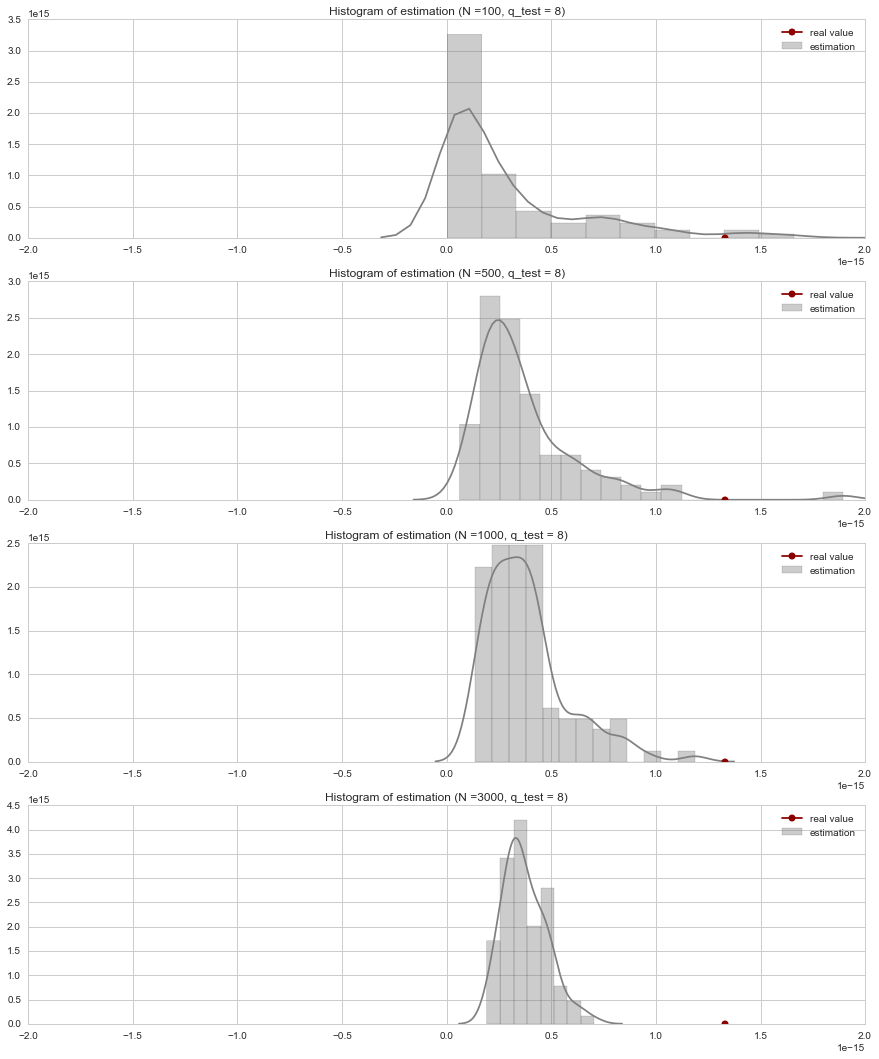

In [263]:
##fluctuation
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(estimation_sim[i], label = "estimation",color = "grey")
    plt.title('Histogram of estimation (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-15,15,0.1)
    plt.plot(p,0,marker = "o",color = 'darkred',label = "real value")
    plt.legend()
    plt.xlim([-2e-15,2e-15])


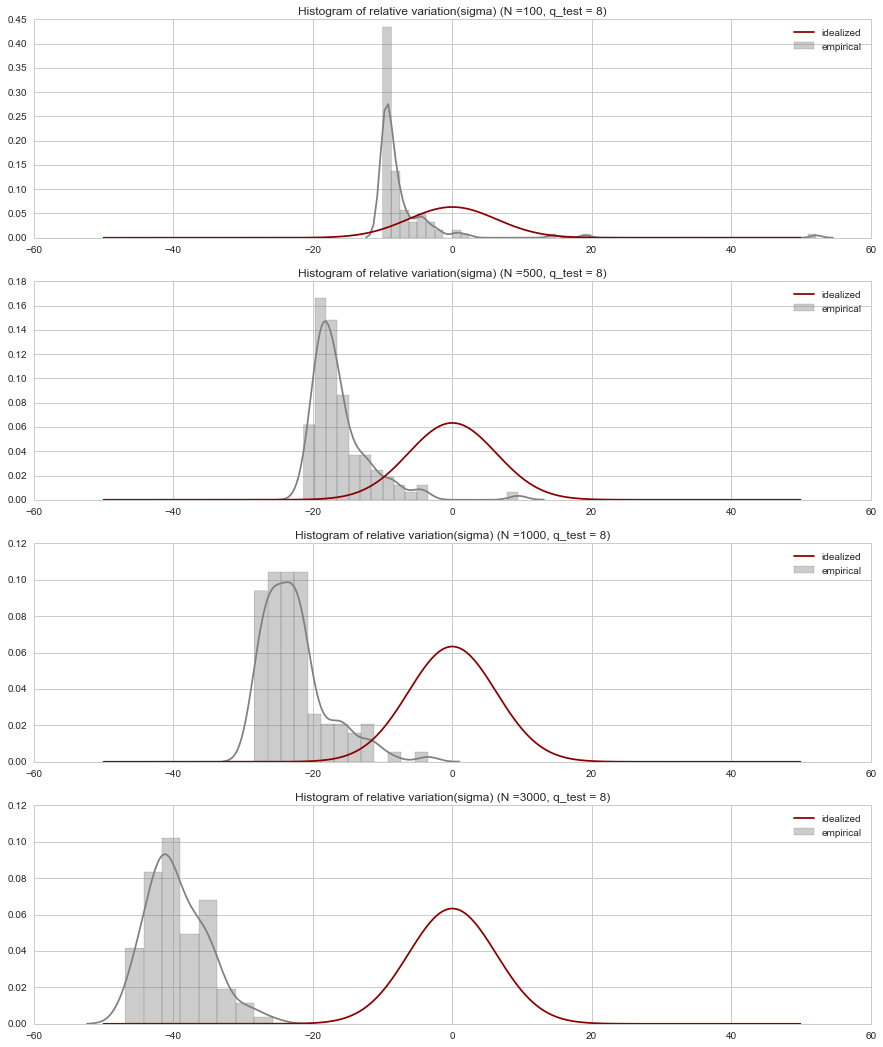

In [264]:
##fluctuation of variance(sigma)
plt.figure(figsize = [15,18])
for i in range(n_choice_N):
    plt.subplot(n_choice_N,1,i+1)

    sns.distplot(sigma_relative_variation_sim[i] , label = "empirical",color = "grey")
    plt.title('Histogram of relative variation(sigma) (N ='+str(list_N[i])+', q_test = 8)')
    x = np.arange(-50,50,0.1)
    plt.plot(x,norm.pdf(x,0,sigma_theoretical), label = "idealized", color = "darkred")
    plt.legend()
    #plt.xlim([-50,50])



(0, 3250)

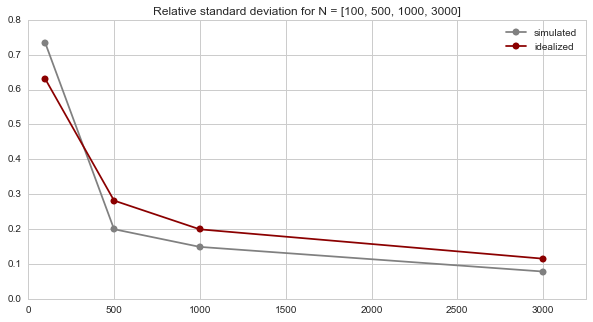

In [265]:
plt.figure(figsize = [10,5])
plt.plot(list_N, std_sqrtN/ np.sqrt(list_N), label = "simulated", marker = 'o',color ="grey")
plt.plot(list_N,  sigma_theoretical /np.sqrt(list_N), label = "idealized", marker = 'o' ,color = "darkred"   ) 
plt.legend()

plt.title("Relative standard deviation for N = "+str(list_N))
plt.xlim([0,3250])

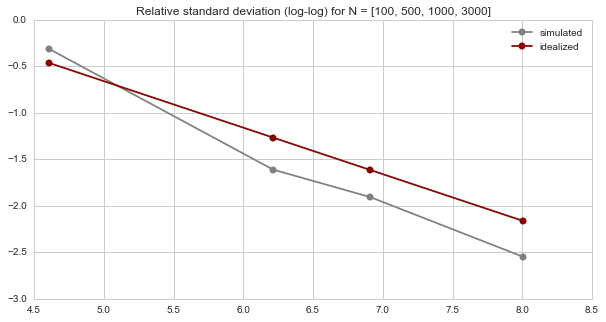

In [266]:
plt.figure(figsize = [10,5])
plt.plot(np.log(list_N), np.log(std_sqrtN/ np.sqrt(list_N)), label = "simulated", marker = 'o',color ="grey")
plt.plot(np.log(list_N),  np.log(sigma_theoretical /np.sqrt(list_N)), label = "idealized", marker = 'o' ,color ="darkred"   ) 
plt.legend()
plt.title("Relative standard deviation (log-log) for N = "+str(list_N))


In [267]:
std_sqrtN_to0 = np.array([np.mean(sigma_relative_variation_sim[i]**2) for i in range(n_choice_N)])
print ("\sqrt N * std of relative deviation : ", std_sqrtN_to0 )

('\\sqrt N * std of relative deviation : ', array([   99.60597709,   278.48182556,   530.91025115,  1570.79720558]))
